In [1]:
data_path = '/content/college_data.json'

In [2]:
import json
import time
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import nltk

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [3]:
def read_data(file_path):
  pairs = [] 
  with open(data_path, 'r') as f:
    data = json.load(f)

  return data  

In [4]:
data = read_data(data_path)

## Making Data Ready

In [5]:
training_sentences = []
training_labels = []
labels = []
responses = []

for intent in data['intents']:
  for pattern in intent['patterns']:
    training_sentences.append(pattern)
    training_labels.append(intent['tag'])
  responses.append(intent['responses'])

  if intent['tag'] not in labels:
    labels.append(intent['tag'])

NUM_CLASSES = len(labels)
print(NUM_CLASSES)

30


In [6]:
pairs = []
for i in range(len(training_sentences)):
  pairs.append((training_sentences[i], training_labels[i]))

random.shuffle(pairs)

In [7]:
pairs[5]

('नमस्ते', 'greeting')

In [8]:
queries = [pair[0] for pair in pairs]
labels = [pair[1] for pair in pairs]

In [9]:
queries[5], labels[5]

('नमस्ते', 'greeting')

In [10]:
le = LabelEncoder()
le.fit(training_labels)
y = le.transform(labels)

In [11]:
vocab_size = 1000
embedding_dim = 32
max_len = 20
oov_token = '<OOV>'

In [12]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(queries)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(queries)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)

In [13]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [14]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [15]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 token_and_position_embeddin  (None, 20, 32)           32640     
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 20, 32)           10656     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(
    padded_sequences,
    np.array(y),
    batch_size=32, epochs=100
)

Epoch 1/100
6/6 [==============================] - 9s 172ms/step - loss: 3.4028 - accuracy: 0.0174
Epoch 2/100
6/6 [==============================] - 1s 169ms/step - loss: 3.3982 - accuracy: 0.0465
Epoch 3/100
6/6 [==============================] - 1s 108ms/step - loss: 3.3517 - accuracy: 0.0698
Epoch 4/100
6/6 [==============================] - 1s 179ms/step - loss: 3.3422 - accuracy: 0.0581
Epoch 5/100
6/6 [==============================] - 1s 111ms/step - loss: 3.3092 - accuracy: 0.0465
Epoch 6/100
6/6 [==============================] - 1s 111ms/step - loss: 3.2736 - accuracy: 0.0930
Epoch 7/100
6/6 [==============================] - 0s 42ms/step - loss: 3.2494 - accuracy: 0.0814
Epoch 8/100
6/6 [==============================] - 1s 75ms/step - loss: 3.1814 - accuracy: 0.1221
Epoch 9/100
6/6 [==============================] - 0s 9ms/step - loss: 3.1820 - accuracy: 0.1279
Epoch 10/100
6/6 [==============================] - 0s 42ms/step - loss: 3.0999 - accuracy: 0.1395
Epoch 11/100
6

In [19]:
def plot_graphs(history, metric):
    plt.plot(history.history.history[metric])
    # plt.plot(history.history.history['val_'+ metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    # plt.legend([metric, 'val_' + metric])

In [31]:
plt.rcParams.update({'font.size': 22})

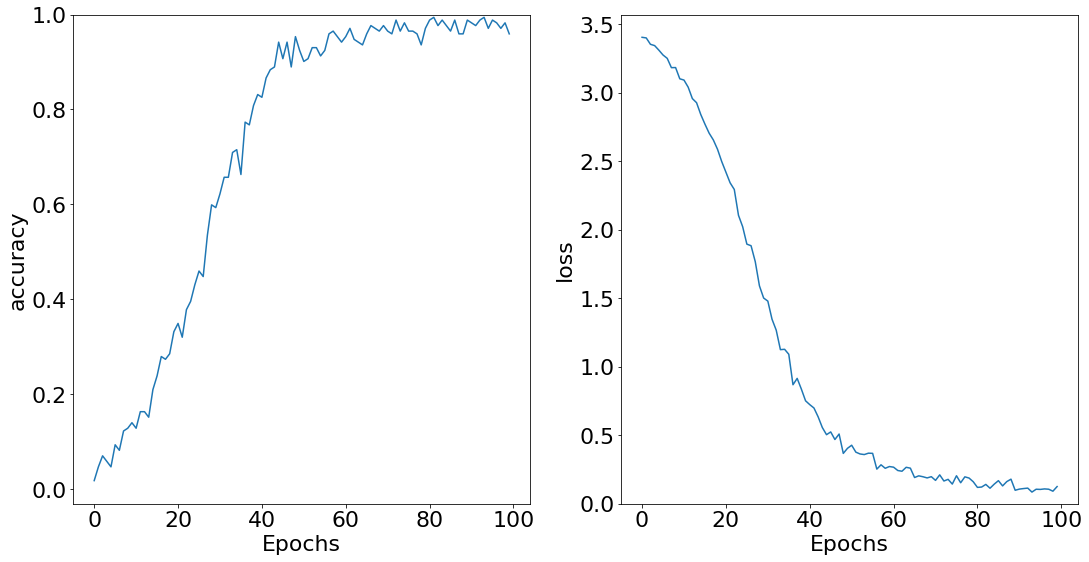

In [33]:
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plot_graphs(model, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(model, 'loss')
plt.ylim(0, None)
plt.savefig('result', dpi=200, transparent=True, format='svg')

<Figure size 432x288 with 0 Axes>

In [70]:
inp = 'कम्प्युटर इन्जिनियरिङमा सिट हुन्छ?'

result = model.predict(tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                             truncating='post', maxlen=max_len), verbose=0)
tag = le.inverse_transform([np.argmax(result)])
print(tag)

['computerengineeringseats']


In [71]:
# to save the trained model
model.save("/content/drive/MyDrive/Major Project/chat_model")

import pickle

# to save the fitted tokenizer
with open('/content/drive/MyDrive/Major Project/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# to save the fitted label encoder
with open('/content/drive/MyDrive/Major Project/label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(le, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
storage = pd.DataFrame(columns=['Date'])

In [ ]:
storage.to_csv('/content/drive/MyDrive/Colab Notebooks/Chatbot/storage.csv', index=False)

In [ ]:
import json 
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

import random
import pickle

with open(data_path) as file:
    data = json.load(file)

storage = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chatbot/storage.csv')

import spacy

NER = spacy.load("en_core_web_sm")




def chat():
    # load trained model
    model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Chatbot/chat_model')

    # load tokenizer object
    with open('/content/drive/MyDrive/Colab Notebooks/Chatbot/tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # load label encoder object
    with open('/content/drive/MyDrive/Colab Notebooks/Chatbot/label_encoder.pickle', 'rb') as enc:
        le = pickle.load(enc)

    # parameters
    max_len = 20
    
    while True:
        print("User: ")
        inp = input()
        text = NER(inp)
        for word in text.ents:
          if word.label_ == 'DATE':
            storage['Date'] = word
        if inp.lower() == "quit":
            break

        result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                             truncating='post', maxlen=max_len), verbose=0)
        tag = le.inverse_transform([np.argmax(result)])

        for i in data['intents']:
            if i['tag'] == tag:
                print("ChatBot:" + np.random.choice(i['responses']))

In [ ]:
print("Start messaging with the bot (type quit to stop)!")
chat()

Start messaging with the bot (type quit to stop)!
User: 
hi
ChatBot:Hello! Welcome to Online Event Managemen Corp. How can I help you?
User: 
i want to book an event
ChatBot:Its simple you just need to provide few details.
 Would you mind providing the event date?
User: 
Friday
ChatBot:And what is the occassion?
User: 
Birthday
ChatBot:I have booked the event for you. Thank you for choosing us.
User: 
Thanks
ChatBot:You're most welcome!
User: 
quit


In [ ]:
storage.head()

,Date
0,Friday
